# Welter issue #17
## Teff vs order
### Part 1: Make a Table

Michael Gully-Santiago  
Monday, June 28, 2016  

See [Issue17](https://github.com/BrownDwarf/welter/issues/17)

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

In [3]:
import pandas as pd

## Retrieve aggregated data for single-$T_{\rm eff}$ Starfish runs for all spectral orders.

In [4]:
IG_run01 = pd.read_csv('../data/analysis/IGRINS_LkCa4_run01_last20kMCMC.csv')
IG_run02 = pd.read_csv('../data/analysis/IGRINS_LkCa4_run02_last20kMCMC.csv')
ES_run01 = pd.read_csv('../data/analysis/IGRINS_ESPaDOnS_run01_last10kMCMC.csv')

Add metadata and merge the data into a single DataFrame:
- Use H-band from Run01
- Use K-band from Run02
- Trim extra columns from ESPaDoNs
- Add `Instrument` column
- Add `Run` column
- *optional* Add run bounds

In [5]:
IG_run01['Run_num'] = 'run01'
IG_run02['Run_num'] = 'run02'

IG = pd.concat([IG_run01[IG_run01.band=='H'], 
                IG_run02[IG_run01.band=='K']], ignore_index=True)

IG['Instrument'] = 'IGRINS'

In [6]:
ES_run01.rename(columns={"m_val_x":"m_val"}, inplace=True)
ES_run01.drop(['m_val_y', 'm_int'], axis=1, inplace=True)

#print(set(IG.columns)-set(ES_run01.columns))
ES_run01['Instrument'] = 'ESPaDoNs'
ES_run01['Run_num'] = 'run01'
ES_run01['band'] = 'VRI'
ES_run01['tell_trans'] = 1.0 #Approximately...

SF_single_Teff = pd.concat([ES_run01, IG], ignore_index=True)
SF_single_Teff = SF_single_Teff[IG.columns]

## Demarcate upper limits

In [7]:
SF_single_Teff['up_limit'] = False

In [8]:
bi = ((SF_single_Teff.Teff_05p < 3530) & 
      (SF_single_Teff.Instrument == 'IGRINS') & 
      (SF_single_Teff.Run_num == 'run01'))

In [9]:
SF_single_Teff.up_limit[bi] = True

## Read in the flux ratio

In [16]:
bb_rat = pd.read_csv('../data/analysis/rat_BB_2800_4100.csv', )
phx_rat = pd.read_csv('../data/analysis/rat_PHX_2800_4100.csv',)

## Plot of $T_{eff}$ vs. spectral order

In [10]:
orders = SF_single_Teff
N_orders = len(orders)

In [11]:
sns.set_style('ticks')

In [35]:
sns.set_context('paper', font_scale=1.25)

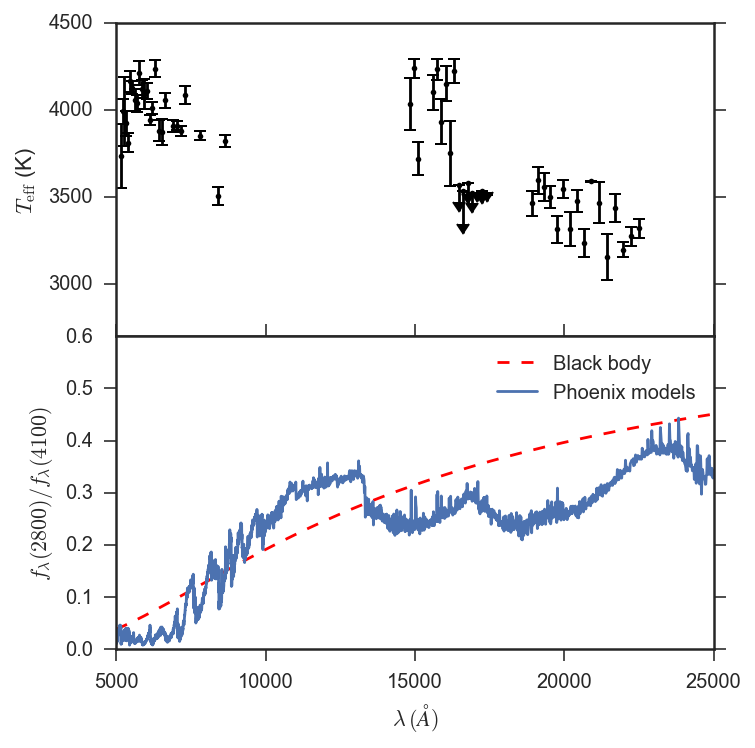

In [53]:
fig = plt.figure(figsize=(5, 5))

fig.subplots_adjust(left=0.09, bottom=0.08, hspace=0.0, right=0.92, top=0.95)

# Plot 1 - Teff vs wavelength
ax1 = fig.add_subplot(211)

#ax.plot(orders.wl_center, orders.Teff_50p, 'k.', alpha=1.0)
yerr = orders.Teff_95p - orders.Teff_50p
ax1.errorbar(orders.wl_center, orders.Teff_50p, yerr=yerr, fmt='k.', uplims=orders.up_limit, capthick=1, alpha=1.0)
ax1.xaxis.set_major_locator(plt.NullLocator())

ax1.set_ylim(2700, 4500)
ax1.set_xlim(5000, 26000)
ax1.set_ylabel('$T_{\mathrm{eff}}$ (K)')
#ax.set_xlabel('$\lambda \,(\AA $)')


ax = fig.add_subplot(212)

ax.plot(bb_rat.wavelength, bb_rat.ratio, 'r--', label='Black body')
ax.plot(phx_rat.wavelength, phx_rat.ratio, label = 'Phoenix models')

ax.set_xlabel('$\lambda \, (\AA)$')
ax.set_ylabel('$f_\lambda(2800) / f_\lambda(4100)$')
ax.legend(loc='best')
ax.set_xlim(5000, 25000)
ax.set_ylim(0, 0.6)

plt.savefig('../document/figures/single_Teff_v_order.pdf', bbox_inches='tight')

## Make a Latex Table of Single $T_{\rm eff}$ for all orders

In [14]:
latex_out = pd.DataFrame()

In [15]:
finite_orders = orders[orders.Teff_50p == orders.Teff_50p]

In [16]:
fo = finite_orders.sort_values('wl_center')

In [17]:
latex_out['Order'] = fo.m_val

In [18]:
latex_out['Instrument'] = fo.Instrument

In [19]:
latex_out['wavelength_range'] = (fo.wl_start.apply(lambda x:"{}".format(int(np.floor(x))))+'$-$'+
       fo.wl_end.apply(lambda x:"{}".format(int(np.ceil(x)))))

We want plus/minus ranges: $3800^{+100}_{-50}$

`3800^{+100}_{-50}`

In [20]:
fo['plus_error'] = fo.Teff_95p-fo.Teff_50p
fo['minus_error'] = fo.Teff_50p-fo.Teff_05p

In [21]:
latex_out['Teff'] = ('$'+fo.Teff_50p.apply(lambda x:"{}".format(int(x)))+'^{+'+
                     fo.plus_error.apply(lambda x:"{}".format(int(x)))+'}_{-'+
                     fo.minus_error.apply(lambda x:"{}".format(int(x)))+'}$')

In [22]:
latex_out.Teff[fo.up_limit] = ('$<'+fo.Teff_95p.apply(lambda x:"{}".format(int(x)))+'$')

In [23]:
latex_out['Teff1'], latex_out['Teff2'], latex_out['f'] = np.NaN, np.NaN, np.NaN

In [24]:
latex_out.to_latex('../document/tables/tbl_order_results_raw.tex', na_rep='---', index=False, escape=False)

In [28]:
orders.to_csv('../data/analysis/orders_LkCa4_oneTeff.csv', index=False)
latex_out.to_csv('../data/analysis/latex_TeffOrder_table.csv', index=False)

## The end.